In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import collections

np.set_printoptions(precision=2, linewidth=200)

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import seaborn as sns

In [3]:
from utils.reader import europarl_raw_data

In [4]:
from utils.attn_graph import AttentionModel

In [5]:
def show_dict_contents(d):
    for k, v in d.items():
        for k2, v2 in v.items():
            print('{0: <30}: type={1: <30}{2}{3}'.format(
                '{0}.{1}'.format(k, k2),
                str(type(v2)),
                ' shape={0}'.format(v2.shape) if isinstance(v2, np.ndarray) else '',
                ' len={0}, contents type={1}'.format(
                    len(v2),
                    type(v2[0])
                ) if isinstance(v2, list) else '',
            ))

In [6]:
def unvectorize_sentence(sentence, idx2word):
    return ' '.join([idx2word[i] 
                     for i in sentence
                     if idx2word[i] != '<bos>' and idx2word[i] != '<eos>' and idx2word[i] != '<pad>'
                    ])

In [7]:
def sample_group(data, group_num, num_samples=10):
    samples = np.random.choice(len(data['train']['X'][group_num]), size=num_samples)
    for sample in samples:
        print(unvectorize_sentence(data['train']['X'][group_num][sample], data['vocab']['lang1_idx2word']))
        print(unvectorize_sentence(data['train']['y'][group_num][sample], data['vocab']['lang2_idx2word']))
        print()

In [9]:
data = europarl_raw_data()
show_dict_contents(data)
print(
    [(x.shape, y.shape) for x, y in sorted(zip(data['train']['X'], data['train']['y']), key=lambda t: t[0].shape[1]) if x.shape[1] > 2]
)

vocab.lang1_idx2word          : type=<class 'list'>                 len=93800, contents type=<class 'str'>
vocab.lang1_word2idx          : type=<class 'dict'>                
vocab.lang2_idx2word          : type=<class 'list'>                 len=44248, contents type=<class 'str'>
vocab.lang2_word2idx          : type=<class 'dict'>                
train.X                       : type=<class 'list'>                 len=4, contents type=<class 'numpy.ndarray'>
train.y                       : type=<class 'list'>                 len=4, contents type=<class 'numpy.ndarray'>
val.X                         : type=<class 'numpy.ndarray'>        shape=(160000, 604)
val.y                         : type=<class 'list'>                 len=160000, contents type=<class 'str'>
test.X                        : type=<class 'numpy.ndarray'>        shape=(160209, 640)
test.y                        : type=<class 'list'>                 len=160209, contents type=<class 'str'>
[((63624, 8), (63624, 32)), ((29

In [10]:
sample_group(data, 0, num_samples=5)

Das ist das Problem .
Therein lies the problem .

Mitglied der Kommission .
Member of the Commission .

( Beifall )
( Applause )

Europa leidet an knappen Kassen .
It is budgetary resources that Europe sorely lacks .

Die Aussprache ist geschlossen .
The debate is closed .



In [11]:
data['train']['X'][1].shape

(297434, 16)

In [46]:
tf.reset_default_graph()
model = AttentionModel(data['vocab']['lang1_idx2word'], data['vocab']['lang2_idx2word'], 128, 512)
all_graphs = model.make_all_graphs(16, data['train']['X'], data['train']['y'])
eval_graph = model.make_eval_graph(16, 30, 32, data['vocab']['lang2_word2idx']['<bos>'])
writer = tf.summary.FileWriter(logdir='logs', graph=tf.get_default_graph())
writer.flush()

In [27]:
all_graphs[1]['inputs_and_outputs']['placeholders']['inputs']

<tf.Tensor 'placeholders_len14/inputs:0' shape=(16, 14) dtype=int32>

In [15]:
show_dict_contents(eval_graph)

placeholders.inputs           : type=<class 'tensorflow.python.framework.ops.Tensor'>
outputs.outputs               : type=<class 'tensorflow.python.framework.ops.Tensor'>
outputs.attention_weights     : type=<class 'tensorflow.python.framework.ops.Tensor'>


In [16]:
data['train']['X'][3].shape

(241295, 32)

In [17]:
np.set_printoptions(precision=2, linewidth=250)

In [68]:
sns.set(font_scale=1.2)
sns.set_style({'savefig.dpi': 100})
def plot_attention_map(eval_input, eval_output_tokens, eval_output_weights, correct_output, lang1_idx2word, lang2_idx2word):
    print('Input:', unvectorize_sentence(eval_input, lang1_idx2word))
    print('Model output:', unvectorize_sentence(eval_output_tokens, lang2_idx2word))
    print('Correct output:', correct_output)
    input_words = [lang1_idx2word[i] for i in eval_input]
    output_words = [lang2_idx2word[i] for i in eval_output_tokens]
    ax = sns.heatmap(
        eval_output_weights,
        xticklabels=input_words,
        yticklabels=output_words,
        linewidths=0.1)
    ax.xaxis.tick_top()
    plt.xticks(rotation=90)
    fig = ax.get_figure()
    fig.set_size_inches(12, 12)
    plt.show()   


In [37]:
INITIAL_LR=5e0
MAX_NORM=1
with tf.Session() as sess:
    run_id = time.time()
    logdir = 'logs/{0}'.format(run_id)
    print('run_id:', run_id)
    writer = tf.summary.FileWriter(logdir, sess.graph)
    coord = tf.train.Coordinator()
    sess.run(tf.global_variables_initializer())
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

    learning_rate = INITIAL_LR
    max_norm = MAX_NORM
    training_outputs = {
        **all_graphs[1]['inputs_and_outputs']['outputs'],
        **all_graphs[1]['inputs_and_outputs']['train_ops'],
    }
    num_batches = (data['train']['X'][1].shape[0] // 100) // 16
    print('num_batches: ', num_batches)
    for i in range(num_batches * 50):
        for j in range(100):
            start_idx = ((i % num_batches) * 100 + j) * 16
            end_idx = ((i % num_batches) * 100 + j+1) * 16
            inputs = data['train']['X'][1][start_idx:end_idx, 1:-1]
            targets = data['train']['y'][1][start_idx:end_idx]
            outputs = sess.run(
                training_outputs,
                feed_dict={
                    all_graphs[1]['inputs_and_outputs']['placeholders']['inputs']: inputs,
                    all_graphs[1]['inputs_and_outputs']['placeholders']['targets']: targets,
                    all_graphs[1]['inputs_and_outputs']['placeholders']['learning_rate']: learning_rate, # * (10.0 / (10.0 + np.sqrt(i))),
                    all_graphs[1]['inputs_and_outputs']['placeholders']['max_norm']: max_norm,
                }
            )
            if j % 25 == 24:
                writer.add_summary(outputs['summary'], global_step=i*100+j)
        model.save(sess, '{0}/model.ckpt'.format(logdir), global_step=i*100+j)

        
        
        

    # Bookkeeping        
    writer.close()
    coord.request_stop()
    coord.join(threads)
    
commented_out = """
        samples = np.random.choice(len(data['val']['X']), size=16)
        eval_inputs = data['val']['X'][samples][:,1:31]
        correct_outputs = [data['val']['y'][sample] for sample in samples]
#         samples = np.arange(16)
#         eval_inputs = data['train']['X'][3][samples][:,1:31]
#         correct_outputs = [
#             unvectorize_sentence(data['train']['y'][3][sample], data['vocab']['lang2_idx2word'])
#             for sample in samples
#         ]
        eval_outputs = sess.run(
            eval_graph['outputs'],
            feed_dict={
                eval_graph['placeholders']['inputs']: eval_inputs,
            }
        )
        print('-' * 40)
        print('i = {0}'.format(i))
        print(outputs)
        for sample_idx, sample in enumerate(samples):
            plot_attention_map(eval_inputs[sample_idx], eval_outputs['outputs'][sample_idx], eval_outputs['attention_weights'][sample_idx], correct_outputs[sample_idx], data['vocab']['lang1_idx2word'], data['vocab']['lang2_idx2word'])
#             print(unvectorize_sentence(eval_inputs[sample_idx], data['vocab']['lang1_idx2word']))
#             print(correct_outputs[sample_idx])
#             print(unvectorize_sentence(eval_outputs['outputs'][sample_idx], data['vocab']['lang2_idx2word']))
#             print(eval_outputs['attention_weights'][sample_idx])
#             print()
        print('-' * 40)
"""

run_id: 1518579346.979142
num_batches:  185


KeyboardInterrupt: 

INFO:tensorflow:Restoring parameters from logs/1518579346.979142/model.ckpt-32699
----------------------------------------
i = 327
Input: Mit den vorgesehenen <unk> sollen Einsparungen in Höhe von 150 Mio. ECU erzielt werden .
Model output: The Danube Strategy should be spent in more detail .
Correct output: <bos> We are told that by cancelling things we could save ECU 150 million . <eos>


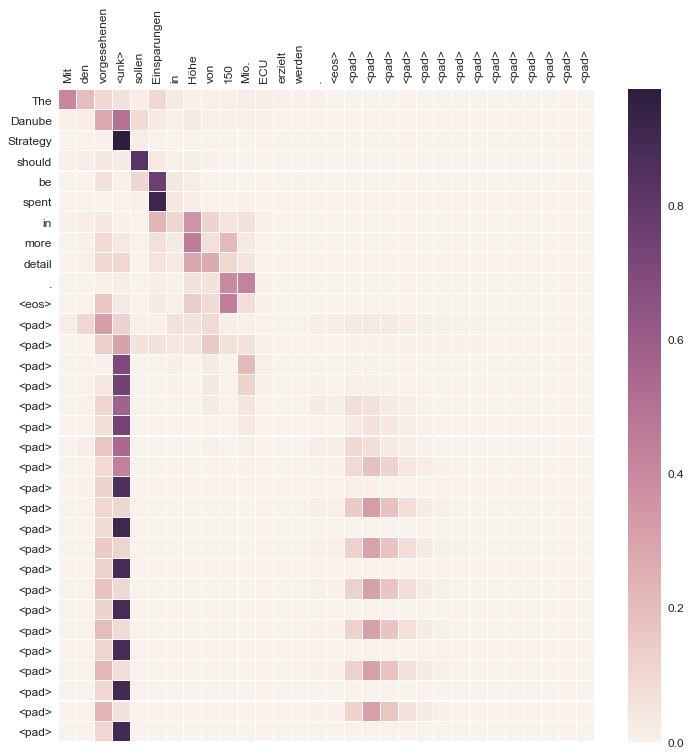

Input: Sie hat sich als gute <unk> erwiesen .
Model output: It has proved to be a good <unk> .
Correct output: <bos> It has been a good balancing measure . <eos>


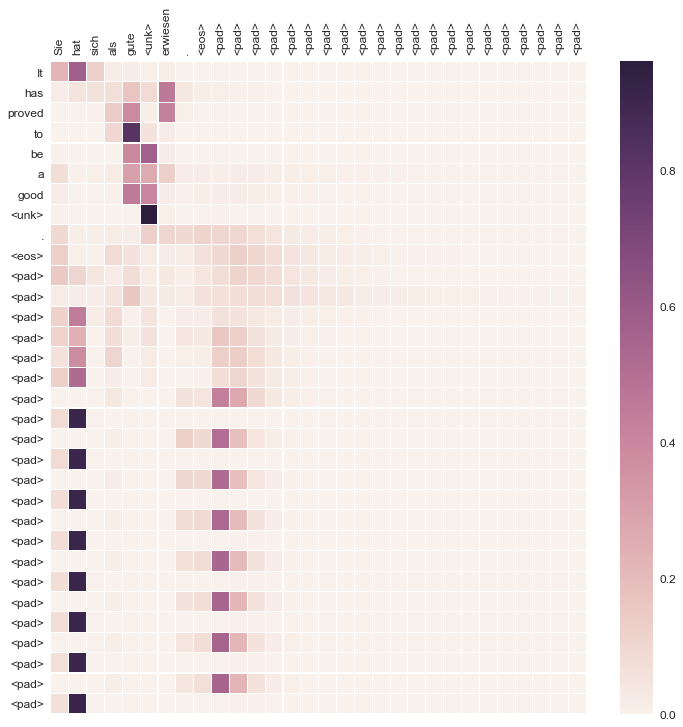

Input: Lassen Sie mich abschließend unserem Kollegen Howitt - auch wenn wir hier jetzt sehr einsam in der Runde stehen - ausdrücklich für das danken , was er getan hat .
Model output: Finally , let me have my voice to thank you , Mr Barroso , for this .
Correct output: <bos> Finally , and even though we are rather depleted in number , I should specifically like to thank Mr Howitt for what he has achieved . <eos>


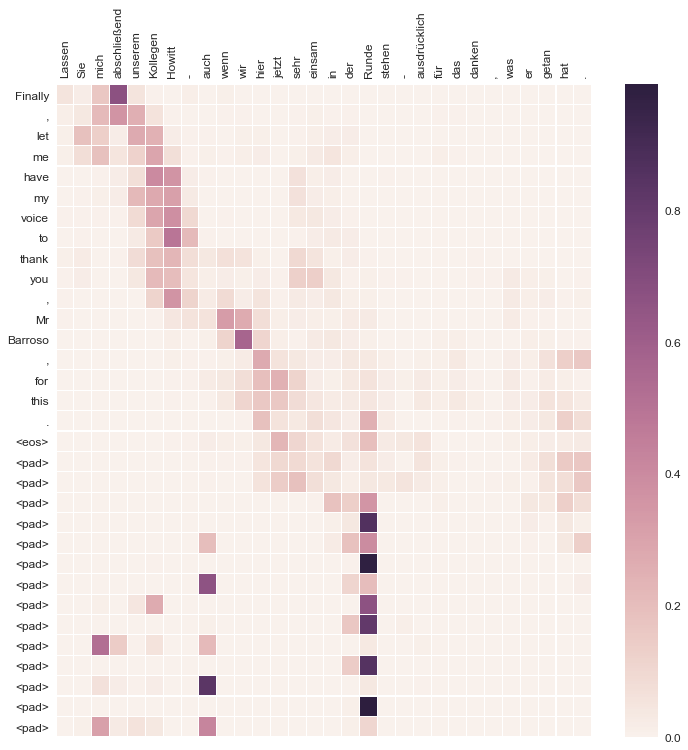

Input: Es gibt außerdem ein Beschäftigungsproblem : Viele <unk> haben ihre Tätigkeit bereits eingestellt , und wir möchten sicherlich nicht für weitere Fälle dieser Art verantwortlich sein .
Model output: There are also a major principle to be involved in terms of such as we should not .
Correct output: <bos> There is also a problem of employment : many road haulage companies have already closed , and we certainly do not wish to be responsible for further closures . <eos>


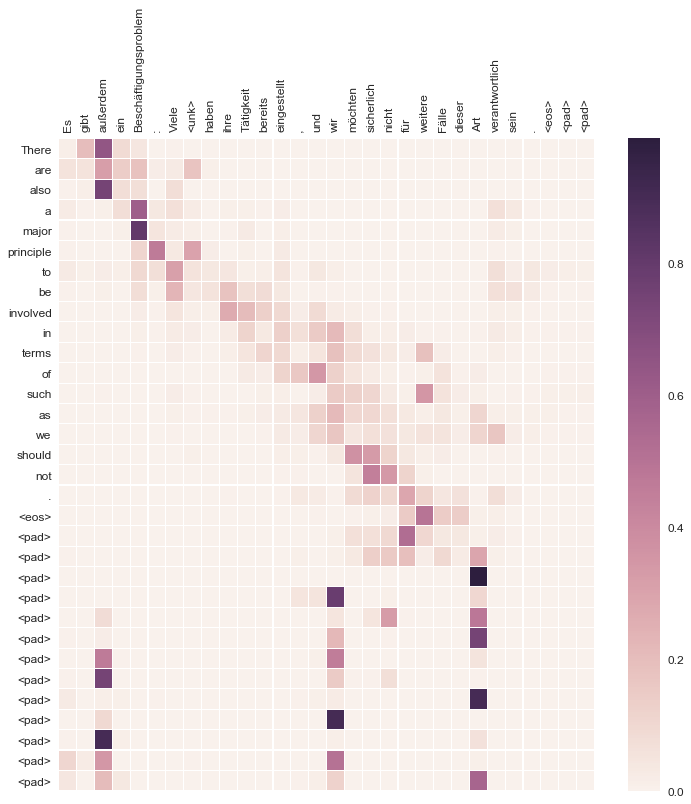

Input: Mein Gehalt als Präsident liegt 40 % über dem eines <unk> .
Model output: My question as regards data .
Correct output: <bos> My salary as President is 40 % higher than the salary of an Executive Director . <eos>


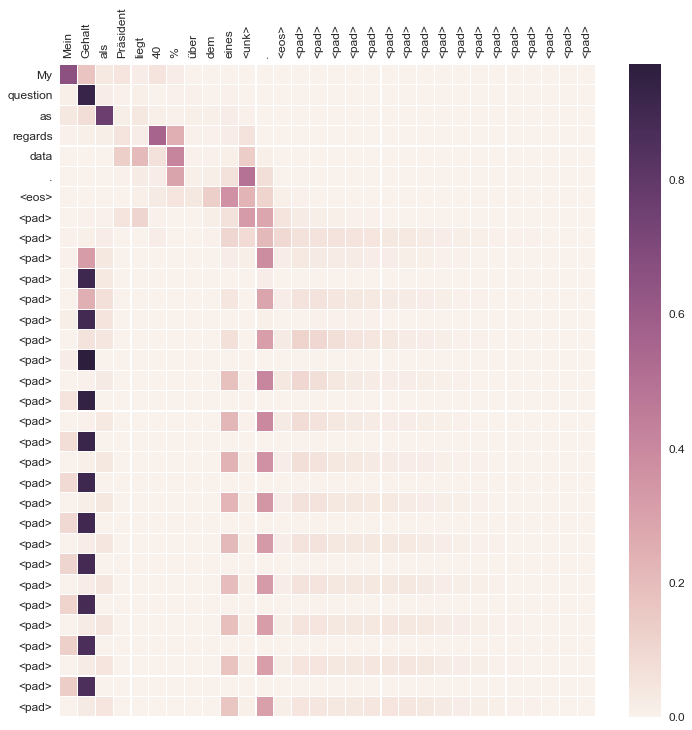

Input: Das Wort hat jetzt Frau <unk> .
Model output: Now the floor has now been called to speak .
Correct output: <bos> Mrs Mowlam now has the floor . <eos>


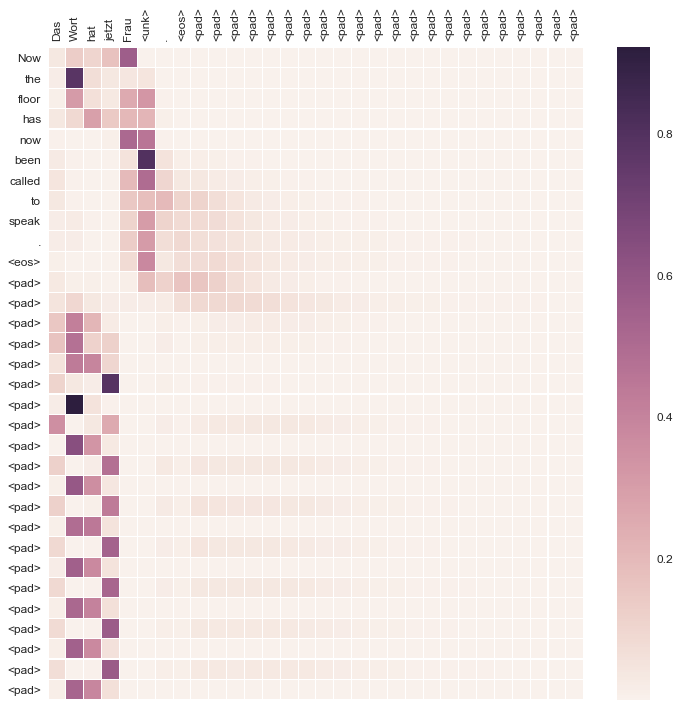

Input: Diese sechzehn Jahre , die ich unter Ihnen verbracht habe , sind für mich eine so reiche Erfahrung , daß ich hoffe , eine bestimmte Reihe von Arbeiten in der
Model output: I have come to find you , and I have a very good part in that regard .
Correct output: <bos> These past sixteen years among you have been such a rich experience for me that I hope to be able to influence some of the questions with which the French National Assembly is involved , especially those that concern the European Union . <eos>


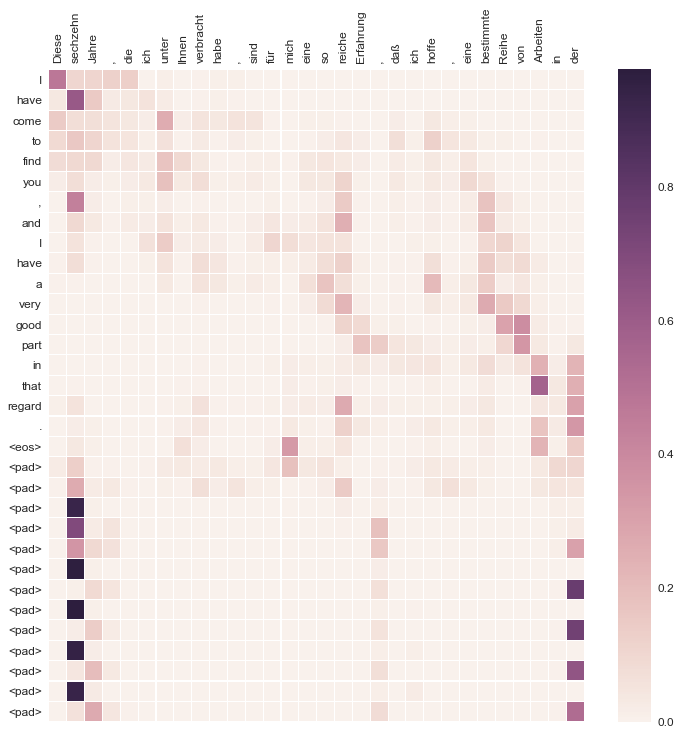

Input: Darüber hinaus hebt die Kommission in ihrem Bericht erstmals auch die Tatsache hervor , daß die Europäische Union in großem Maße eine internationale <unk> darstellt .
Model output: Moreover , the Commission is also taking the fact that the European Union is in a large range of international cooperation .
Correct output: <bos> In addition , for the first time in the Commission &apos;s report they also highlight the fact that the European Union is largely an internal trading community . <eos>


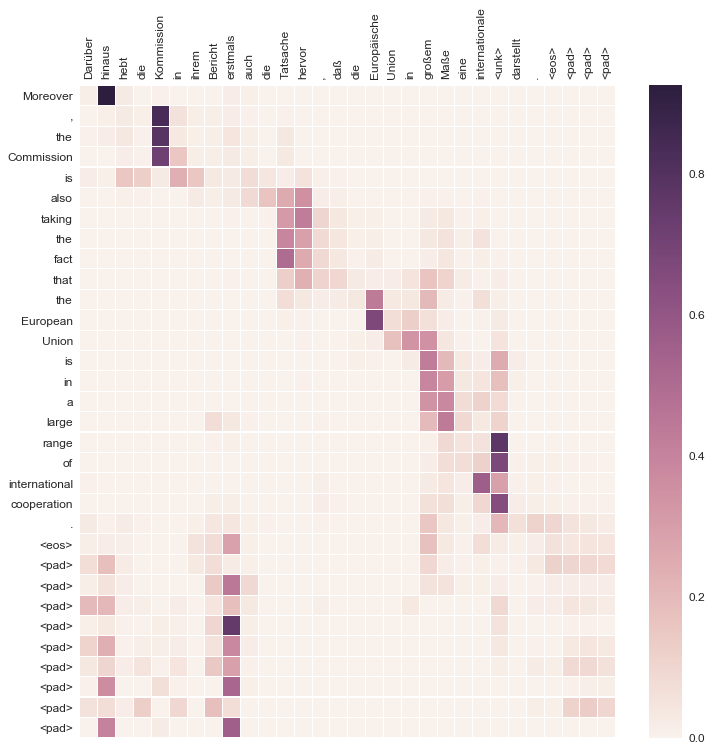

Input: Deshalb bleibt meine Fraktion dabei .
Model output: That is why my group is in favour .
Correct output: <bos> That is why my group is being so tenacious about this . <eos>


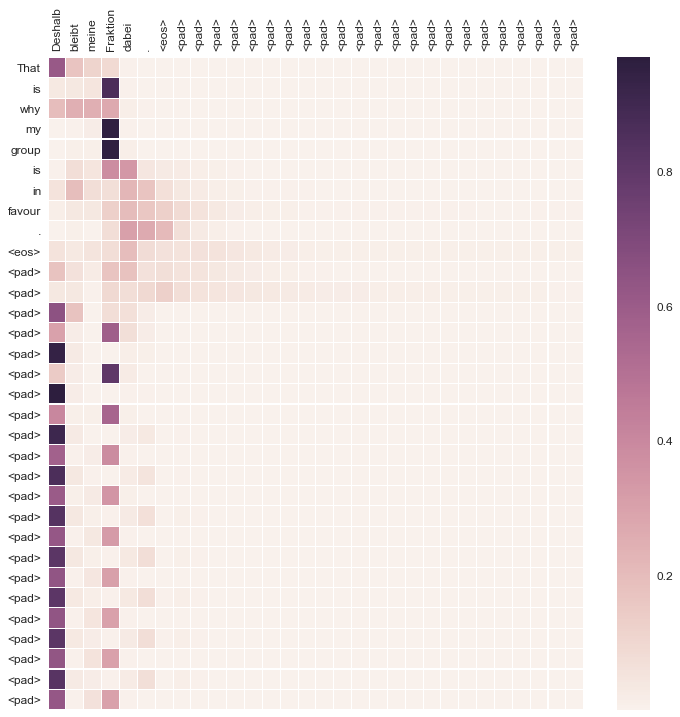

Input: Es kann nicht sein , daß diese Themen ohne ordentliche Prüfung durch das Parlament <unk> werden .
Model output: It cannot be that these matters are being carried out .
Correct output: <bos> It cannot be that those issues are transferred without proper parliamentary scrutiny . <eos>


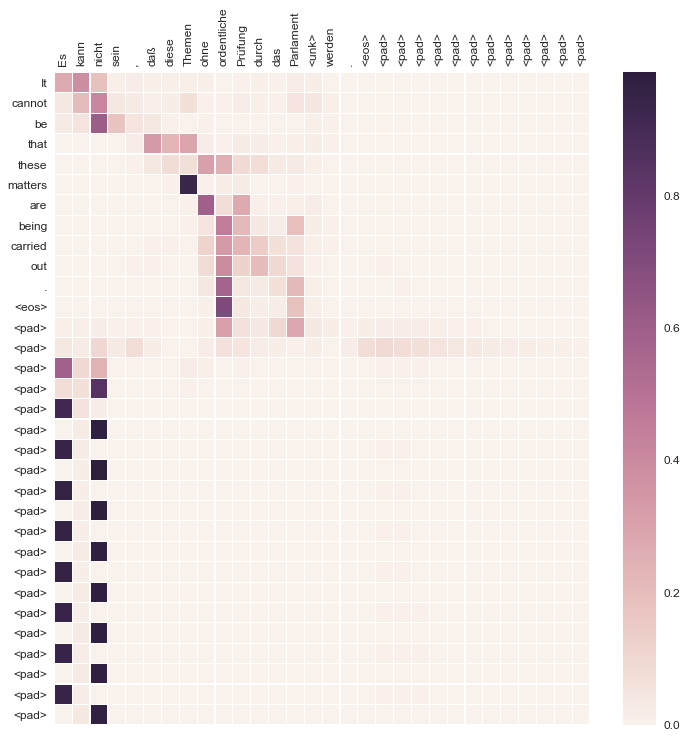

Input: Die Entschlossenheit sämtlicher europäischer Institutionen zur Durchführung des Aktionsplans für den Binnenmarkt stellt einen wichtigen Schritt dar .
Model output: The European Union &apos;s activities in favour of the European Union &apos;s budget .
Correct output: <bos> The determination of all the EU institutions to implement the Single Market action plan is a major step . <eos>


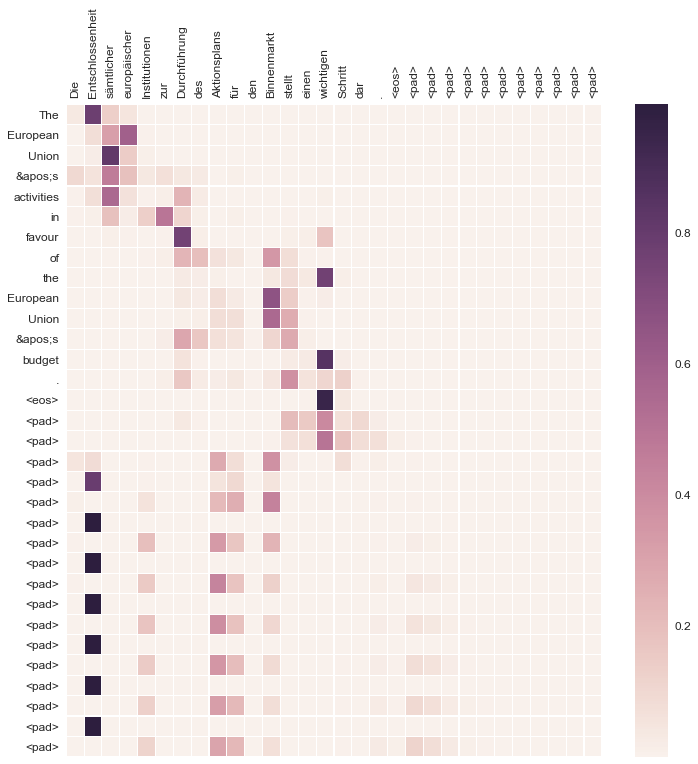

Input: Wir müssen den Beitrittsprozeß beschleunigen .
Model output: We need to move on with the <unk> .
Correct output: <bos> Speed up the timetable for accession . <eos>


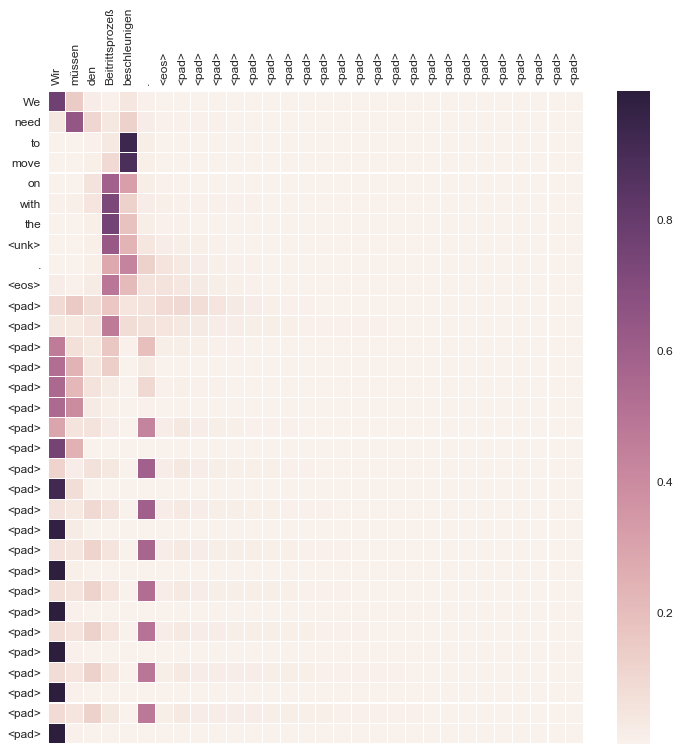

Input: Meiner Ansicht nach formen diese drei Kulturen die kulturelle Realität eines jeden <unk> , der sich als Spanier fühlt .
Model output: I believe that these three cultures is in a real way .
Correct output: <bos> I believe that the three cultures have combined to create the cultural identity of all true Spaniards . <eos>


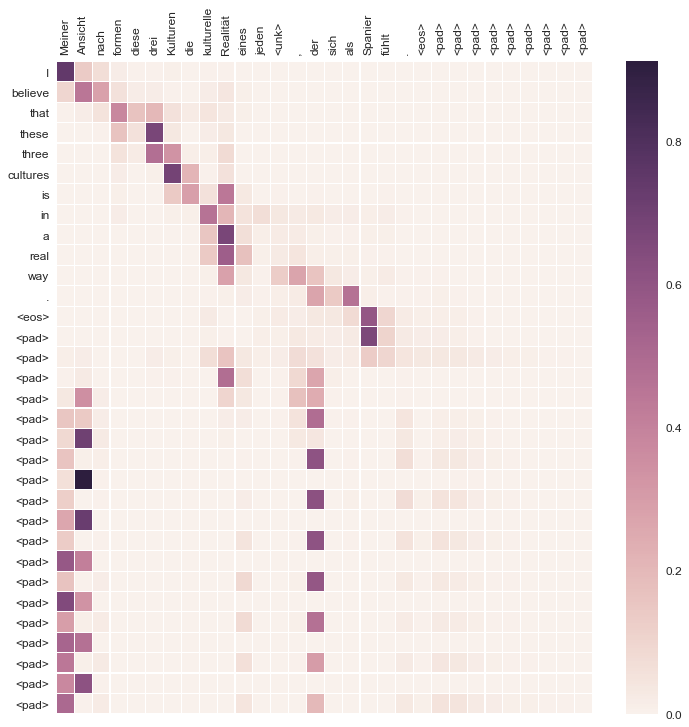

Input: Mit anderen Worten , es könnten Waren im Rahmen des Versandverfahrens - beispielsweise von Hamburg nach München - ohne Einhaltung des Systems der Sicherheitsleistung oder gar ohne jegliche Sicherheitsleistung transportiert
Model output: In view of the Danube , for example , to be used in accordance with the Schengen acquis , for example ?
Correct output: <bos> The Commission proposes that the operator &apos;s liability should end when he has performed his contractual obligations , in other words , on presentation of the goods and documents to the office of destination . <eos>


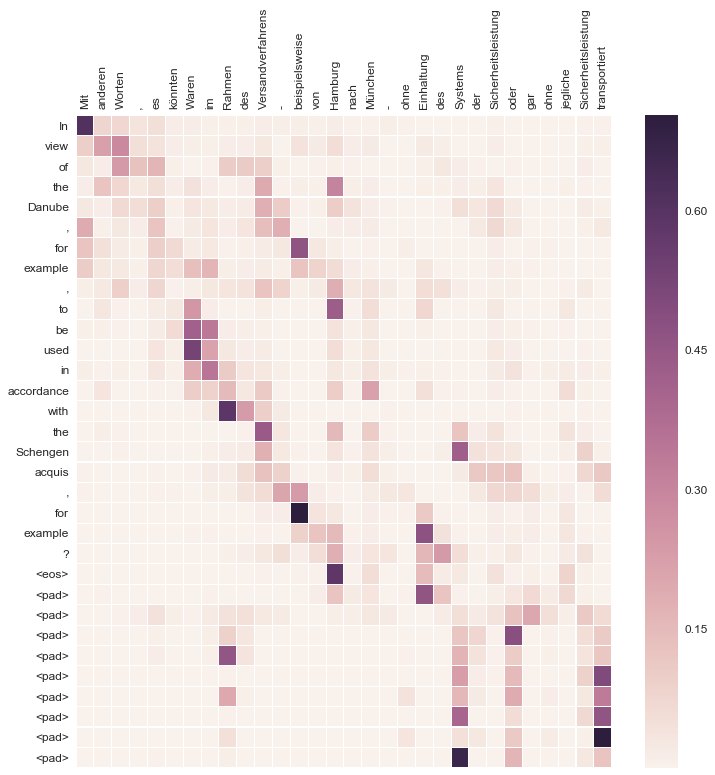

Input: Sie ist die logische Folge eines Binnenmarktes , der sich vollendet und in dem der Wettbewerb nicht mehr durch Kursschwankungen verzerrt werden wird .
Model output: They are not being seen as a result of the internal market .
Correct output: <bos> It is the logical final piece in a single market which is nearing completion and within which exchange rate fluctuations will no longer disrupt competition . <eos>


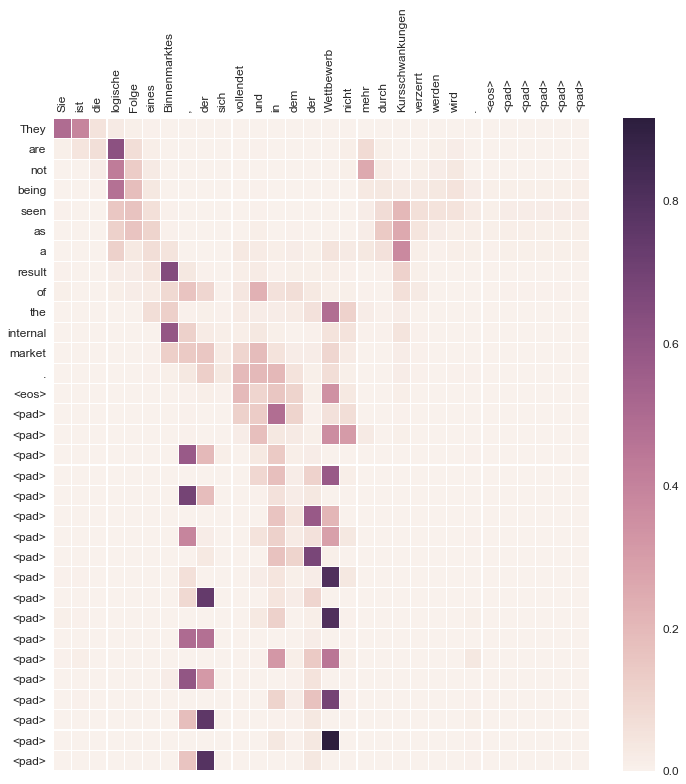

Input: Als ich einen Landsmann von mir fragte , was er davon hält , faßte der seine Meinung , gestützt auf Erfahrung , in einem Satz zusammen .
Model output: As I have been called for a comment , to take note of it , it has been thinking .
Correct output: <bos> When I asked a compatriot what he thought of it , he summarized his opinion , based on experience , in one phrase . <eos>


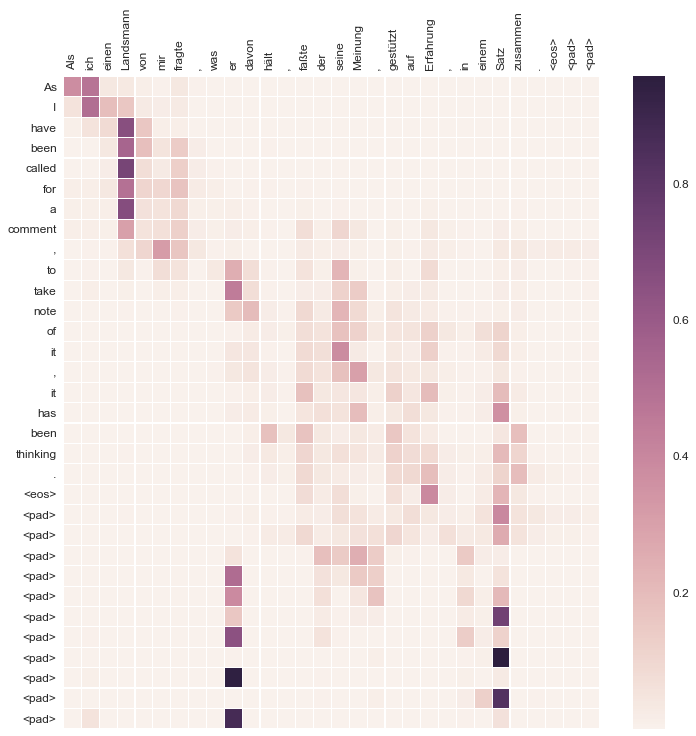

----------------------------------------


In [71]:
with tf.Session() as sess:
    logdir = 'logs/1518579346.979142'
    ckpt = 32699
    model.restore(sess, '{0}/model.ckpt-{1}'.format(logdir, ckpt))
    samples = np.random.choice(len(data['val']['X']), size=16)
    eval_inputs = data['val']['X'][samples][:,1:31]
    correct_outputs = [data['val']['y'][sample] for sample in samples]
#         samples = np.arange(16)
#         eval_inputs = data['train']['X'][3][samples][:,1:31]
#         correct_outputs = [
#             unvectorize_sentence(data['train']['y'][3][sample], data['vocab']['lang2_idx2word'])
#             for sample in samples
#         ]
    eval_outputs = sess.run(
        eval_graph['outputs'],
        feed_dict={
            eval_graph['placeholders']['inputs']: eval_inputs,
        }
    )
    print('-' * 40)
    print('i = {0}'.format(i))
    for sample_idx, sample in enumerate(samples):
        plot_attention_map(eval_inputs[sample_idx], eval_outputs['outputs'][sample_idx], eval_outputs['attention_weights'][sample_idx], correct_outputs[sample_idx], data['vocab']['lang1_idx2word'], data['vocab']['lang2_idx2word'])
#             print(unvectorize_sentence(eval_inputs[sample_idx], data['vocab']['lang1_idx2word']))
#             print(correct_outputs[sample_idx])
#             print(unvectorize_sentence(eval_outputs['outputs'][sample_idx], data['vocab']['lang2_idx2word']))
#             print(eval_outputs['attention_weights'][sample_idx])
#             print()
    print('-' * 40)


In [48]:
eval_outputs.keys()

dict_keys(['outputs', 'attention_weights', 'attention_weights_as_array'])

In [50]:
len(eval_outputs['attention_weights_as_array'])

32

In [52]:
eval_outputs['attention_weights_as_array'][0][-1]

array([  2.56e-01,   3.82e-01,   1.50e-01,   5.51e-02,   1.24e-01,   1.43e-02,   8.93e-03,   2.02e-03,   4.62e-04,   4.46e-04,   6.36e-04,   2.44e-03,   4.13e-04,   2.20e-04,   2.24e-04,   1.22e-05,   1.63e-04,   1.61e-04,   4.11e-04,   2.66e-04,
         6.43e-04,   5.36e-04,   9.67e-04,   3.95e-05,   2.28e-05,   9.39e-07,   5.86e-06,   9.75e-06,   1.51e-06,   8.42e-06], dtype=float32)

In [53]:
eval_outputs['attention_weights'].shape

(16, 32, 30)

In [54]:
eval_outputs['attention_weights'][-1,0,:]

array([  2.56e-01,   3.82e-01,   1.50e-01,   5.51e-02,   1.24e-01,   1.43e-02,   8.93e-03,   2.02e-03,   4.62e-04,   4.46e-04,   6.36e-04,   2.44e-03,   4.13e-04,   2.20e-04,   2.24e-04,   1.22e-05,   1.63e-04,   1.61e-04,   4.11e-04,   2.66e-04,
         6.43e-04,   5.36e-04,   9.67e-04,   3.95e-05,   2.28e-05,   9.39e-07,   5.86e-06,   9.75e-06,   1.51e-06,   8.42e-06], dtype=float32)

Input: Auch der Punkt der Bekämpfung der Armut ist dabei sehr wichtig .
Model output: The issue of combating poverty is very important .
Correct output: <bos> The battle against poverty is also very important here . <eos>


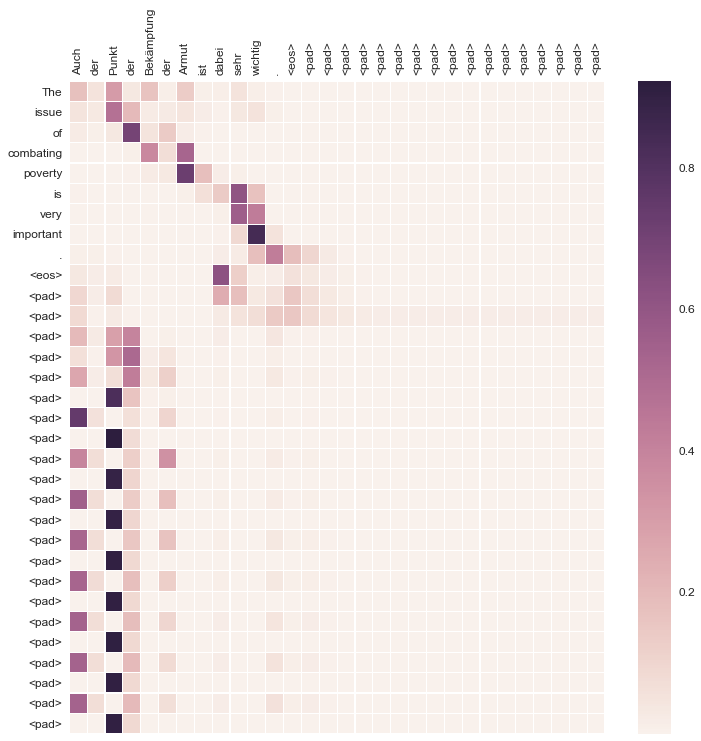

In [69]:
plot_attention_map(eval_inputs[sample_idx], eval_outputs['outputs'][sample_idx], eval_outputs['attention_weights'][sample_idx], correct_outputs[sample_idx], data['vocab']['lang1_idx2word'], data['vocab']['lang2_idx2word'])

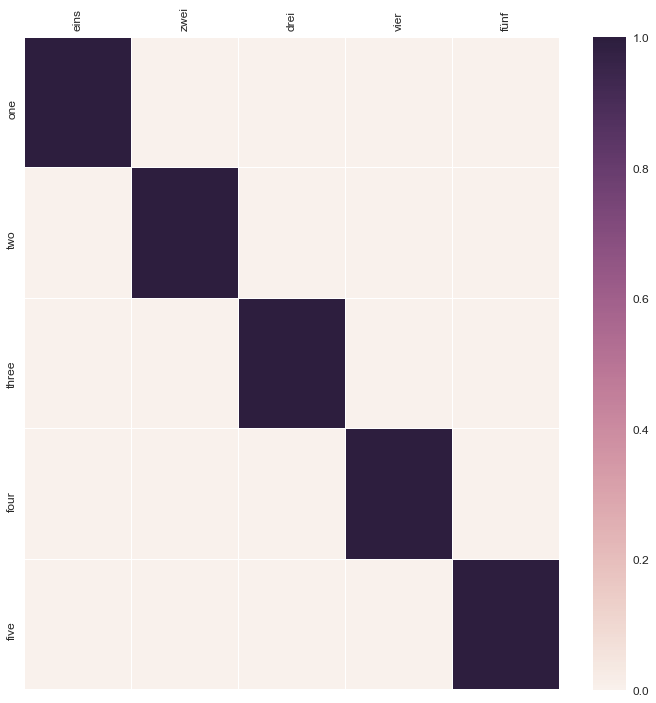

In [67]:
input_words = ['eins', 'zwei', 'drei', 'vier', 'fünf']
output_words = ['one', 'two', 'three', 'four', 'five']
ax = sns.heatmap(
    np.eye(5),
    linewidths=0.1,
    xticklabels=input_words,
    yticklabels=output_words,
)
ax.xaxis.tick_top()
fig = ax.get_figure()
fig.set_size_inches(12, 12)
plt.xticks(rotation=90)
plt.show()
foo = """

input_words = [lang1_idx2word[i] for i in eval_input]
output_words = [lang2_idx2word[i] for i in eval_output_tokens]
ax.set_yticklabels(output_words)
fig = ax.get_figure()
fig.set_size_inches(12, 12)
plt.show()   
"""
